In [1]:
import numpy as np
import pandas as pd

In [2]:
%cd Z:\PPMI_Data\Excels\CollaborativeFiltering
df = pd.read_csv("Feats_Patient_LongCol.csv")
print(df.shape)
df.head(2)

Z:\PPMI_Data\Excels\CollaborativeFiltering
(7380, 3)


,Patient_ID,Features,Severity
0,1,Benton,0
1,2,Benton,1


C:\Users\system 4\AppData\Local\Temp\ipykernel_5632\723460866.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


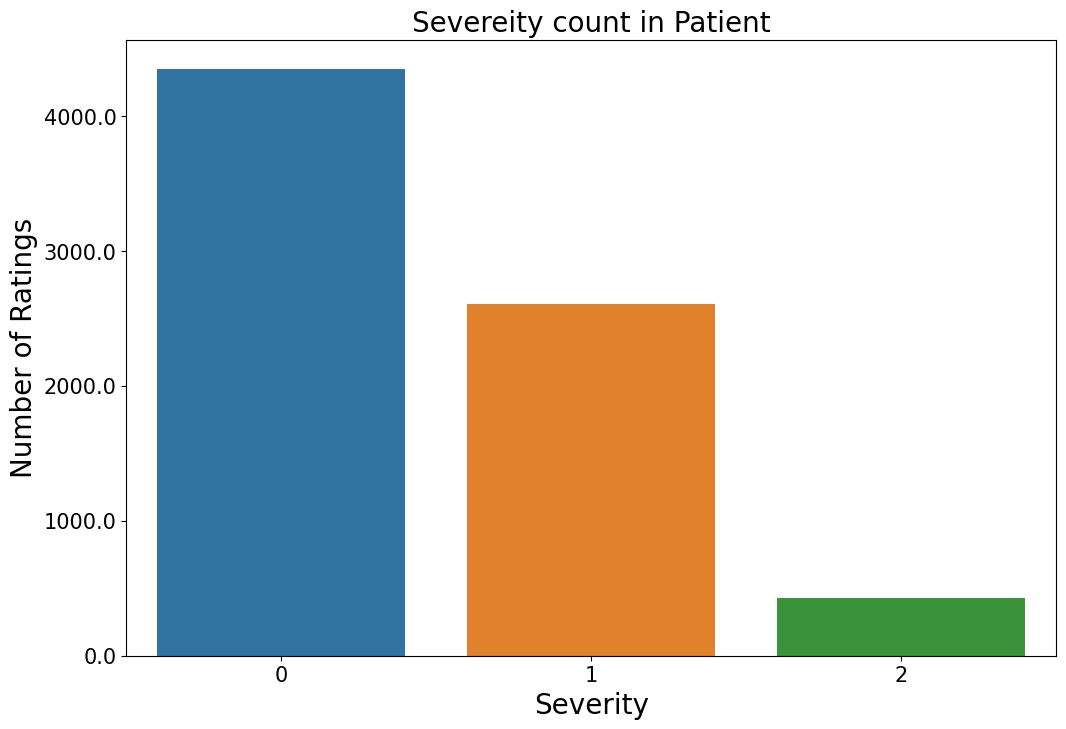

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Severity", data=df)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Severeity count in Patient", fontsize = 20)
plt.xlabel("Severity", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

## Features with 'Highest' Values

In [3]:
num_rating_df = df.groupby('Features').count()['Severity'].reset_index()
num_rating_df.rename(columns={'Severity':'num_Severity'},inplace=True)
num_rating_df.head(2)

,Features,num_Severity
0,Benton,164
1,COGSTATE,164


In [4]:
avg_rating_df = df.groupby('Features').mean()['Severity'].reset_index()
avg_rating_df.rename(columns={'Severity':'avg_Severity'},inplace=True)
avg_rating_df.head(2)

,Features,avg_Severity
0,Benton,0.317073
1,COGSTATE,0.109756


In [5]:
popular_df = num_rating_df.merge(avg_rating_df,on='Features')
popular_df.head(2)

,Features,num_Severity,avg_Severity
0,Benton,164,0.317073
1,COGSTATE,164,0.109756


In [6]:
popular_df = popular_df[popular_df['num_Severity']>=150].sort_values('avg_Severity',ascending=False)

In [7]:
print(popular_df.shape)
popular_df.head(2)

(45, 3)


,Features,num_Severity,avg_Severity
44,UPSIT,164,1.243902
41,Symbol Digit,164,1.207317


popular_df = popular_df.merge(books,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Image-URL-M','num_ratings','avg_rating']]

## Collaborative Filtering Based Recommender System

In [8]:
# Selecting only those patient who have data of more than 40 tests/features 
# Here all patients have 45 tests/features
x = df.groupby('Patient_ID').count()['Severity'] > 40
padhe_likhe_users = x[x].index

In [9]:
# Patient ID we got above, now merging with their data
filtered_rating = df[df['Patient_ID'].isin(padhe_likhe_users)]
print(filtered_rating)
filtered_rating.head(2)

      Patient_ID Features  Severity
0              1   Benton         0
1              2   Benton         1
2              3   Benton         0
3              4   Benton         1
4              5   Benton         0
...          ...      ...       ...
7375         160    UPSIT         1
7376         161    UPSIT         1
7377         162    UPSIT         2
7378         163    UPSIT         1
7379         164    UPSIT         2

[7380 rows x 3 columns]


,Patient_ID,Features,Severity
0,1,Benton,0
1,2,Benton,1


In [10]:
# Selecting only those features which are present in at least 50 patients
# Here all 164 patients have all 45 features data, so any data will not be removed
y = filtered_rating.groupby('Features').count()['Severity']>=50
famous_books = y[y].index
print(famous_books.shape)

(45,)


In [11]:
# Creating final dataframe
# Here all are same as earlier
final_ratings = filtered_rating[filtered_rating['Features'].isin(famous_books)]
print(final_ratings.shape)
final_ratings.head(2)

(7380, 3)


,Patient_ID,Features,Severity
0,1,Benton,0
1,2,Benton,1


In [12]:
# Creating pivot table
# Features in row
pt = final_ratings.pivot_table(index='Features',columns='Patient_ID',values='Severity')
print(pt.shape)
pt.head(2)

(45, 164)


Patient_ID,1,2,3,4,5,6,7,8,9,10,...,155,156,157,158,159,160,161,162,163,164
Features,,,,,,,,,,,,,,,,,,,,,
Benton,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
COGSTATE,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
# Creating similarity score of every feature with every other features
similarity_scores = cosine_similarity(pt)
print(similarity_scores.shape)

(45, 45)


In [15]:
def recommend(Feature):
    # index fetch
    index = np.where(pt.index==Feature)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:6]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = df[df['Features'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Features')['Features'].values))
        
        data.append(item)
    
    return data

In [27]:
# Type name of feature below to see closely associated features
recommend('UPSIT')

[['LetterNumber'],
 ['Geriatric Depression'],
 ['STAIA'],
 ['Symbol Digit'],
 ['STAIS']]